# plant-seedlings-classification

Can you differentiate a weed from a crop seedling?

The ability to do so effectively can mean better crop yields and better stewardship of the environment.

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, 

has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several 
growth stages.

In [2]:
import pandas as pd
import numpy as np
import os
import imageio
import tensorflow as tensorflow

from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Maximum
from keras.layers import ZeroPadding2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize as imresize
from tqdm import tqdm


C:\Users\rashm\Anaconda3.6\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\rashm\Anaconda3.6\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\rashm\Anaconda3.6\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\rashm\Anaconda3.6\lib\site-packages\tensorboard\compat\tensorflow_stub

In [3]:
tensorflow.__version__

'2.2.0'

In [4]:
## looking at dataset under train and test folders, we can see there are images of 12 classes as below, 
## hence created dictionary for ease
CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

In [5]:
# created encoding of numeric value back to plants category for easy mapping of predicted results 
INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

In [6]:
PATH_TO_PROJECT="D:/PG-AIML/Labs/Assessment/Project12-ComputerVision"

## Reading and preprocessing of train and test images

In [7]:
# Resize all image to 51x51 
def img_reshape(img):
    img = imresize(img, (51, 51, 3))
    return img

# get image tag
def img_label(path):
    return str(str(path.split('/')[-1]))

# get plant class on image
def img_class(path):
    #print("img_class: ",str(path.split("\\")[-2]))
    return str(path.split("\\")[-2])

In [8]:
# fill train and test dict
def fill_dict(paths, some_dict):
    text = ''
    if 'train' in paths[0]:
        text = 'Start fill train_dict'
    elif 'test' in paths[0]:
        text = 'Start fill test_dict'

    for p in tqdm(paths, ascii=True, ncols=85, desc=text):
        img = imageio.imread(p)
        img = img_reshape(img)
        some_dict['image'].append(img)
        some_dict['label'].append(img_label(p))
        if 'train' in paths[0]:
           # print("for train setting class",p)
            some_dict['class'].append(img_class(p))

    return some_dict

In [9]:
# read image from dir. and fill train and test dict
def reader():
    file_ext = []
    train_path = []
    test_path = []

    for root, dirs, files in os.walk(PATH_TO_PROJECT):
        if dirs != []:
            print('Root:\n'+str(root))
            print('Dirs:\n'+str(dirs))
        else:
            for f in files:
                ext = os.path.splitext(str(f))[1][1:]

                if ext not in file_ext:
                    file_ext.append(ext)

                if 'train' in root:
                    path = os.path.join(root, f)
                    train_path.append(path)
                elif 'test' in root:
                    path = os.path.join(root, f)
                    test_path.append(path)
    train_dict = {
        'image': [],
        'label': [],
        'class': []
    }
    test_dict = {
        'image': [],
        'label': []
    }

    train_dict = fill_dict(train_path, train_dict)
    test_dict = fill_dict(test_path, test_dict)
    return train_dict, test_dict


In [10]:
train_dict, test_dict = reader()
X_train = np.array(train_dict['image'])

Start fill train_dict:   0%|                                | 0/4750 [00:00<?, ?it/s]

Root:
D:/PG-AIML/Labs/Assessment/Project12-ComputerVision
Dirs:
['.ipynb_checkpoints', 'data', 'plant-weights', 'test', 'train']
Root:
D:/PG-AIML/Labs/Assessment/Project12-ComputerVision\train
Dirs:
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


Start fill test_dict: 100%|########################| 794/794 [00:12<00:00, 63.33it/s]


In [43]:
train_dict['class'][5]

'Black-grass'

In [44]:
y_train = to_categorical(np.array([CLASS[l] for l in train_dict['class']]))

In [45]:
X_test = np.array(test_dict['image'])
label = test_dict['label']

# Initialisation and building of Network to train

In [46]:
BATCH_SIZE = 32
EPOCHS = 5
RANDOM_STATE = 11

In [47]:
# Conv. layers set
def conv_layer(feature_batch, feature_map, kernel_size=(3, 3),strides=(1,1), zp_flag=False):
    if zp_flag:
        zp = ZeroPadding2D((1,1))(feature_batch)
    else:
        zp = feature_batch
    conv = Conv2D(filters=feature_map, kernel_size=kernel_size, strides=strides)(zp)
    bn = BatchNormalization(axis=3)(conv)
    act = LeakyReLU(1/10)(bn)
    return act

In [48]:
def get_model():
    inp_img = Input(shape=(51, 51, 3))

    # 51
    conv1 = conv_layer(inp_img, 64, zp_flag=False)
    conv2 = conv_layer(conv1, 64, zp_flag=False)
    mp1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)
    # 23
    conv3 = conv_layer(mp1, 128, zp_flag=False)
    conv4 = conv_layer(conv3, 128, zp_flag=False)
    mp2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv4)
    # 9
    conv7 = conv_layer(mp2, 256, zp_flag=False)
    conv8 = conv_layer(conv7, 256, zp_flag=False)
    conv9 = conv_layer(conv8, 256, zp_flag=False)
    mp3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv9)
    # 1
    # dense layers
    flt = Flatten()(mp3)

    dp1 = Dropout(0.)(flt)
    dns1 = Dense(128)(dp1)
    bn1 = BatchNormalization(axis=-1)(dns1)
    ds1 = Activation(activation='tanh')(bn1)
    
    dp2 = Dropout(0.)(ds1)
    dns2 = Dense(12)(dp2)
    bn2 = BatchNormalization(axis=-1)(dns2)
    out = Activation(activation='softmax')(bn2)

    model = Model(inputs=inp_img, outputs=out)
        
    mypotim = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=mypotim, metrics=['accuracy'])
    ##model.summary()
    return model


## TRAIN THE MODEL

In [49]:

def get_callbacks(filepath, patience=5):
    lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=1e-5, patience=patience, verbose=1)
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [lr_reduce, msave]

In [50]:
filepath1= PATH_TO_PROJECT+'/plant-weights/model_weight_SGD.hdf5'
print("filepaths : ",filepath1)
callbacks = get_callbacks(filepath = filepath1, patience=6)
gmodel = get_model()
gmodel.summary()
gmodel.load_weights(filepath1)

filepaths :  D:/PG-AIML/Labs/Assessment/Project12-ComputerVision/plant-weights/model_weight_SGD.hdf5
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 51, 51, 3)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 49, 49, 64)        1792      
_________________________________________________________________
batch_normalization_55 (Batc (None, 49, 49, 64)        256       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
batch_normalization_56 (Batc (None, 47, 47, 64)        256       
________________________

In [51]:
## Splitiing the data in test and train 

In [52]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train,
                                                        y_train,
                                                        shuffle=True,
                                                        train_size=0.8,
                                                        random_state=RANDOM_STATE
                                                        )

In [53]:
## generating aug images
gen = ImageDataGenerator(rotation_range=360., width_shift_range=0.3,
            height_shift_range=0.3,zoom_range=0.3,
            horizontal_flip=True, vertical_flip=True)   

In [54]:
 history=gmodel.fit(gen.flow(x_train, y_train,batch_size=BATCH_SIZE),
               steps_per_epoch=10*len(x_train)/BATCH_SIZE,
               epochs=EPOCHS, verbose=1, shuffle=True,
               validation_data=(x_valid, y_valid),
               callbacks=callbacks)

Epoch 1/5
1188/1187 [==============================] - 2260s 2s/step - loss: 0.0746 - accuracy: 0.9726 - val_loss: 0.0917 - val_accuracy: 0.9674
Epoch 2/5


C:\Users\rashm\Anaconda3.6\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1188/1187 [==============================] - 1878s 2s/step - loss: 0.0665 - accuracy: 0.9759 - val_loss: 0.0942 - val_accuracy: 0.9611
Epoch 3/5
1188/1187 [==============================] - 1817s 2s/step - loss: 0.0655 - accuracy: 0.9762 - val_loss: 0.1161 - val_accuracy: 0.9526
Epoch 4/5
1188/1187 [==============================] - 1657s 1s/step - loss: 0.0640 - accuracy: 0.9765 - val_loss: 0.1238 - val_accuracy: 0.9516
Epoch 5/5
1188/1187 [==============================] - 1558s 1s/step - loss: 0.0588 - accuracy: 0.9792 - val_loss: 0.3387 - val_accuracy: 0.8979


# Prediction Accuracy on Validation data 

In [55]:
from sklearn.metrics import classification_report
# make predictions on the testing images, finding the index of the
probIdxs = gmodel.predict(x=x_valid,verbose=1)
# label with the corresponding largest predicted probability
predIdxs = probIdxs.argmax(axis=-1)

950/950 [==============================] - 8s 8ms/step


In [56]:
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(y_valid.argmax(axis=-1), predIdxs))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.78      0.63      0.69        67
           1       0.94      0.97      0.95        76
           2       0.86      1.00      0.93        56
           3       0.95      0.99      0.97       137
           4       0.92      0.92      0.92        39
           5       0.97      0.83      0.90        83
           6       0.81      0.96      0.87       135
           7       1.00      0.85      0.92        34
           8       0.95      0.78      0.86        99
           9       0.62      0.87      0.72        39
          10       1.00      0.99      1.00       104
          11       0.96      0.85      0.90        81

   micro avg       0.90      0.90      0.90       950
   macro avg       0.90      0.89      0.89       950
weighted avg       0.91      0.90      0.90       950



## Visualising the prediction accuracy with epochs

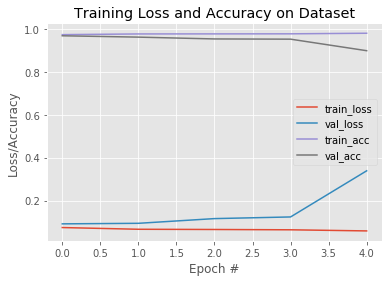

In [57]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt

N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

In [ ]:
## we got the best accuracy after epoch 1 , then it started reducing.

In [58]:
history.history

{'val_loss': [0.09168186352441185,
  0.09423057556152344,
  0.11611999725040636,
  0.12384300131546823,
  0.3386714539088701],
 'val_accuracy': [0.9673684239387512,
  0.961052656173706,
  0.9526315927505493,
  0.9515789747238159,
  0.8978947401046753],
 'loss': [0.07449548831042602,
  0.06648502791825685,
  0.06545697806558393,
  0.06402536897257423,
  0.05880292539177304],
 'accuracy': [0.97263813, 0.9759068, 0.9761704, 0.97646034, 0.9791535],
 'lr': [0.1, 0.1, 0.1, 0.1, 0.1]}

# Trying Other Model with diff Layers combination

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau




class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
		# CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# (CONV => RELU) * 2 => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# (CONV => RELU) * 3 => POOL layer set
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# second set of FC => RELU layers
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

In [70]:
def get_model2():
    model = MiniVGGNet.build(51, 51, 3, 12)
    opt = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.summary()
    return model

In [71]:
filepath3= PATH_TO_PROJECT+'/plant-weights/model2_weight.hdf5'
print("filepaths :",filepath3)
callbacks1 = get_callbacks(filepath = filepath3, patience=6)
gmodel2 = get_model2()

filepaths : D:/PG-AIML/Labs/Assessment/Project12-ComputerVision/plant-weights/model2_weight.hdf5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 51, 51, 32)        896       
_________________________________________________________________
activation_24 (Activation)   (None, 51, 51, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 51, 51, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 64)        18496     
_______________________

In [72]:
history2= gmodel2.fit(gen.flow(x_train, y_train,batch_size=BATCH_SIZE),
               steps_per_epoch=10*len(x_train)/BATCH_SIZE,
               epochs=EPOCHS, verbose=1, shuffle=True, validation_data=(x_valid, y_valid),
               callbacks=callbacks1)

Epoch 1/5
1188/1187 [==============================] - 519s 437ms/step - loss: 1.5978 - accuracy: 0.4993 - val_loss: 1.3771 - val_accuracy: 0.5411 - lr: 0.0020
Epoch 2/5
1188/1187 [==============================] - 505s 425ms/step - loss: 0.8885 - accuracy: 0.7017 - val_loss: 1.6905 - val_accuracy: 0.5284 - lr: 0.0020
Epoch 3/5
1188/1187 [==============================] - 506s 426ms/step - loss: 0.6449 - accuracy: 0.7816 - val_loss: 1.0299 - val_accuracy: 0.6474 - lr: 0.0020
Epoch 4/5
1188/1187 [==============================] - 506s 426ms/step - loss: 0.5275 - accuracy: 0.8195 - val_loss: 0.3304 - val_accuracy: 0.8705 - lr: 0.0020
Epoch 5/5
1188/1187 [==============================] - 535s 450ms/step - loss: 0.4496 - accuracy: 0.8447 - val_loss: 0.5788 - val_accuracy: 0.7937 - lr: 0.0020


In [73]:
probIdxs2 = gmodel2.predict(x=x_valid,verbose=1)
predIdxs2 = probIdxs2.argmax(axis=-1)
print("Evaluating network2...")
print(classification_report(y_valid.argmax(axis=-1), predIdxs2))

30/30 [==============================] - 4s 118ms/step
Evaluating network2...
              precision    recall  f1-score   support

           0       0.15      0.04      0.07        67
           1       0.90      0.86      0.88        76
           2       0.88      0.91      0.89        56
           3       0.96      0.89      0.92       137
           4       0.96      0.67      0.79        39
           5       0.75      0.92      0.83        83
           6       0.62      0.97      0.76       135
           7       1.00      0.62      0.76        34
           8       0.98      0.53      0.68        99
           9       0.57      0.92      0.71        39
          10       0.79      1.00      0.89       104
          11       1.00      0.83      0.91        81

   micro avg       0.79      0.79      0.79       950
   macro avg       0.80      0.76      0.76       950
weighted avg       0.80      0.79      0.78       950



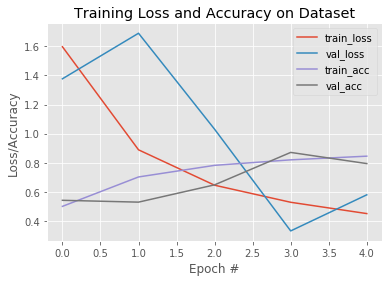

In [74]:
N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history2.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history2.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history2.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

# Conclusion:

We can try many other models for better results, however from above 2 models, 
1st one gave approx 97.9% accuracy on train and 89 on validation dataset.The accuracy was going down, perhaps few more epochs might have needed to find apt model.

The second model could have only ~84% on train and 79% validation.This on every increase of epoch was giving better accuracy for train and test.(somewhere in 4the epoch it reached 87% for val data too and then dropped.)
But yet, the result of first model is better, so I submitted the solution on test data to kaggle, this one gave ~95%.

**Apart from Accuracy: 
a) The number of paramters were less in model1
model1 :Trainable params: 1,772,516
model2 :Trainable params: 3,057,100 **


**b) Time taken in second model was lesser for 5 epochs
Model1 : approx 30 min 1 epoch- 2.5 hours for 5
Model2: just 8-9 min each epoch - 50 min for 5 **

For now, I will consider the model with better accuracy for predicting the class label for test data images.

## Predict labels for TEST images using best of model

In [75]:
## using model 1 to predict values of model1

prob = gmodel.predict(X_test, verbose=1)
pred = prob.argmax(axis=-1)
sub = pd.DataFrame({"file": label,
                    "species": [INV_CLASS[p] for p in pred]})


794/794 [==============================] - 9s 11ms/step


In [76]:
sub.head()

,file,species
0,Project12-ComputerVision\test\0021e90e4.png,Small-flowered Cranesbill
1,Project12-ComputerVision\test\003d61042.png,Fat Hen
2,Project12-ComputerVision\test\007b3da8b.png,Sugar beet
3,Project12-ComputerVision\test\0086a6340.png,Common Chickweed
4,Project12-ComputerVision\test\00c47e980.png,Sugar beet


In [77]:
## saving the result of prediction for test daata in csv file
sub.to_csv("sub2.csv", index=False, header=True)